In [1]:
%run batter_data.ipynb

      T_ID   GDAY_DS  HEADER_NO   P_ID  START_CK  BAT_ORDER_NO   PA   AB  RBI  \
0       HH  20160401          0  60404         0             3    1    1    0   
1       HH  20160401          0  62700         1             9    2    2    0   
2       HH  20160401          0  64086         1             7    6    4    0   
3       HH  20160401          0  66740         1             5    6    6    0   
4       HH  20160401          0  71347         1             2    6    6    1   
...    ...       ...        ...    ...       ...           ...  ...  ...  ...   
18679   WO  20161009          0  74215        91           374  402  341   80   
18680   WO  20161009          0  78168       139           177  646  560   63   
18681   WO  20161009          0  79130        15           251   80   66    7   
18682   WO  20161009          0  79300        13           429  106   91    9   
18683   WO  20161009          0  79365       122           965  454  411   70   

       RUN  ...  BB  IB  HP

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import kerastuner as kt

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import power_transform
from sklearn.decomposition import PCA

from tensorflow import keras

init_notebook_mode(connected = True)

feature, target = batter_data("HT")

C:\Users\jmp08\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
C:\Users\jmp08\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


C:\Users\jmp08\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\jmp08\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\jmp08\Anaconda3\lib\site-packages\ipykernel_launcher.py:134: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\jmp08\Anaconda3\lib\site-packages\ipykernel_launcher.py:140: SettingWithCopyWarning:

In [3]:
feature.columns

Index(['MONEY_BAT', 'AGE_VA_BAT', 'K/PA', 'ISO', 'BABIP_BAT', 'BPF', 'BS_PCA',
       'PA_PCA'],
      dtype='object')

In [3]:
trainFeature = feature.loc[0:feature.shape[0]-120]
trainTarget = target.loc[0:feature.shape[0]-120]

validFeature = feature.loc[feature.shape[0]-120:feature.shape[0]-20].reset_index(drop = True)
validTarget = target.loc[feature.shape[0]-120:feature.shape[0]-20].reset_index(drop = True)

testFeature = feature.loc[feature.shape[0]-20:].reset_index(drop = True)
testTarget = target[feature.shape[0]-20:].reset_index(drop = True)
trainFeature.shape

(481, 15)

In [4]:
scaler = MinMaxScaler()
res = scaler.fit(trainFeature)
res = scaler.transform(trainFeature)
trainFeature = pd.DataFrame(res, columns = trainFeature.columns, index = list(trainFeature.index.values))

res = scaler.transform(validFeature)
validFeature = pd.DataFrame(res, columns = validFeature.columns, index = list(validFeature.index.values))

res = scaler.transform(testFeature)
testFeature = pd.DataFrame(res, columns = testFeature.columns, index = list(testFeature.index.values))

In [5]:
class MCDropout(keras.layers.Dropout) :
    def call(self, inputs) :
        return super().call(inputs, training = True)

model = keras.Sequential()

model.add(keras.layers.Input(shape = (trainFeature.shape[1])))
model.add(keras.layers.Dense(100, activation = "selu", kernel_initializer = "lecun_normal"))
model.add(MCDropout(rate = .2))
model.add(keras.layers.Dense(100, activation = "selu", kernel_initializer = "lecun_normal"))
model.add(MCDropout(rate = .2))
model.add(keras.layers.Dense(100, activation = "selu", kernel_initializer = "lecun_normal"))
model.add(MCDropout(rate = .2))
model.add(keras.layers.Dense(100, activation = "selu", kernel_initializer = "lecun_normal"))
model.add(MCDropout(rate = .2))
model.add(keras.layers.Dense(100, activation = "selu", kernel_initializer = "lecun_normal"))
model.add(MCDropout(rate = .2))
model.add(keras.layers.Dense(100, activation = "selu", kernel_initializer = "lecun_normal"))
model.add(MCDropout(rate = .2))
model.add(keras.layers.Dense(100, activation = "selu", kernel_initializer = "lecun_normal"))
model.add(MCDropout(rate = .2))
model.add(keras.layers.Dense(100, activation = "selu", kernel_initializer = "lecun_normal"))
model.add(MCDropout(rate = .2))
model.add(keras.layers.Dense(100, activation = "selu", kernel_initializer = "lecun_normal"))
model.add(MCDropout(rate = .2))

model.add(keras.layers.Dense(1, activation = None))

optimizer = keras.optimizers.Nadam(learning_rate = 0.001)

model.compile(optimizer = optimizer, loss = keras.losses.Huber())

early_stop = keras.callbacks.EarlyStopping(monitor = "val_loss", min_delta = 0.0001, patience = 30, mode = "min", restore_best_weights = True)

history = model.fit(trainFeature, trainTarget, epochs = 700, validation_data = [validFeature, validTarget], shuffle = False,
                    use_multiprocessing = True, batch_size = 20, callbacks = [early_stop])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 481 samples, validate on 101 samples
Epoch 1/700
481/481 [==============================] - 3s 6ms/sample - loss: 0.8550 - val_loss: 0.8085
Epoch 2/700
481/481 [==============================] - 0s 328us/sample - loss: 0.5872 - val_loss: 0.5212
Epoch 3/700
481/481 [==============================] - 0s 319us/sample - loss: 0.4746 - val_loss: 0.5687
Epoch 4/700
481/481 [==============================] - 0s 328us/sample - loss: 0.4568 - val_loss: 0.8131
Epoch 5/700
481/481 [==============================] - 0s 330us/sample - loss: 0.3608 - val_loss: 0.9977
Epoch 6/700
481/481 [==============================] - 0s 355us/sample - loss: 0.3914 - val_loss: 0.3901
Epoch 7/700
481/481 [==============================] - 0s 340us/sample - loss: 0.3424 - val_loss: 0.5618
Epoch 8/700
481/481 [==============================] - 0s 332us/sample - loss: 0.2911 - val_loss: 0.3630
Epoch 9/700
481/481 [=

In [19]:
result = model.predict(validFeature[-20:]).reshape(20, )
result.mean()

0.2747435

In [20]:
validTarget[-20:].mean()

0.2811484884926742

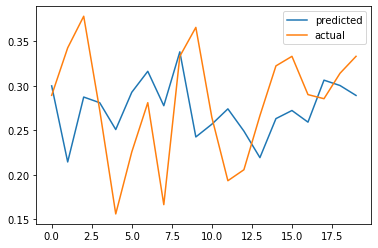

In [22]:
plt.plot(result, label = "predicted")
plt.plot(validTarget[-20:].reset_index(drop = True), label = "actual")
plt.legend()

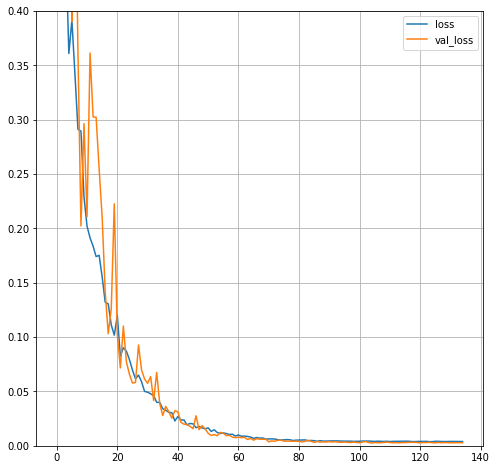

In [24]:
pd.DataFrame(history.history).plot(figsize = (8, 8))
plt.grid(True)
plt.gca().set_ylim(0, .4)
plt.show()

In [25]:
trainTarget.mean()

0.28379087948761805